In [1]:
# Import the libraries
import torch
import torch.optim as optim
from torch import nn
from torchmetrics.functional.regression import r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from dataset import CustomDataset
from preprocess import DataPreprocessing
from model import Net
import train

%matplotlib inline

torch.__version__

c:\Users\User\Documents\Conda\envs\figurenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.1.0+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Set seed to repeat the results
RANDOM_SEED = 99

torch.backends.cudnn.enabled = False
torch.manual_seed(RANDOM_SEED)

In [4]:
img_zip = np.load('C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\image_array.npz')
img_arr = img_zip['arr_0']

dataset = pd.read_csv('C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\image_data.csv')
dataset.head()

,ID,figure,size,color,rotation_angle,center_x,center_y
0,0,square,15,#FFA500,8,-1,-1
1,1,hexagon,11,#FF0000,25,3,4
2,2,hexagon,11,#FF00FF,19,4,-4
3,3,square,15,#FF00FF,18,0,0
4,4,circle,15,#FFFF00,0,-1,-1


In [5]:
data_preprocessing = DataPreprocessing(img_arr, dataset, size=32, color='RGB', test_size=0.2, random_seed=RANDOM_SEED)

labels, scaler_shape, scaler_color, scaler_size, scaler_angle, scaler_xcoord, scaler_ycoord = data_preprocessing.scale()

transform = data_preprocessing.get_transform()

X_train, X_test, y_train, y_test = data_preprocessing.split()
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (20000, 32, 32, 3) (20000, 7)
Test set: (5000, 32, 32, 3) (5000, 7)


In [6]:
train_data = CustomDataset(images=X_train,
                            labels=y_train,
                            transformation=transform)

test_data = CustomDataset(images=X_test,
                            labels=y_test,
                            transformation=transform)

len(train_data), len(test_data)

(20000, 5000)

In [7]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 500
NUM_EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.8

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=BATCH_SIZE_TEST, 
                                          shuffle=False)

In [9]:
img_custom, shape_custom, color_custom, size_custom, angle_custom, xcoord_custom, ycoord_custom = next(iter(test_loader))

print(f"Image: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Shape: {shape_custom.shape}")
print(f"Color: {color_custom.shape}")
print(f"Size: {size_custom.shape}")
print(f"Rotation angle: {angle_custom.shape}")
print(f"X_center: {xcoord_custom.shape}")
print(f"Y_center: {ycoord_custom.shape}")

Image: torch.Size([500, 3, 32, 32]) -> [batch_size, color_channels, height, width]
Shape: torch.Size([500])
Color: torch.Size([500])
Size: torch.Size([500])
Rotation angle: torch.Size([500])
X_center: torch.Size([500])
Y_center: torch.Size([500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


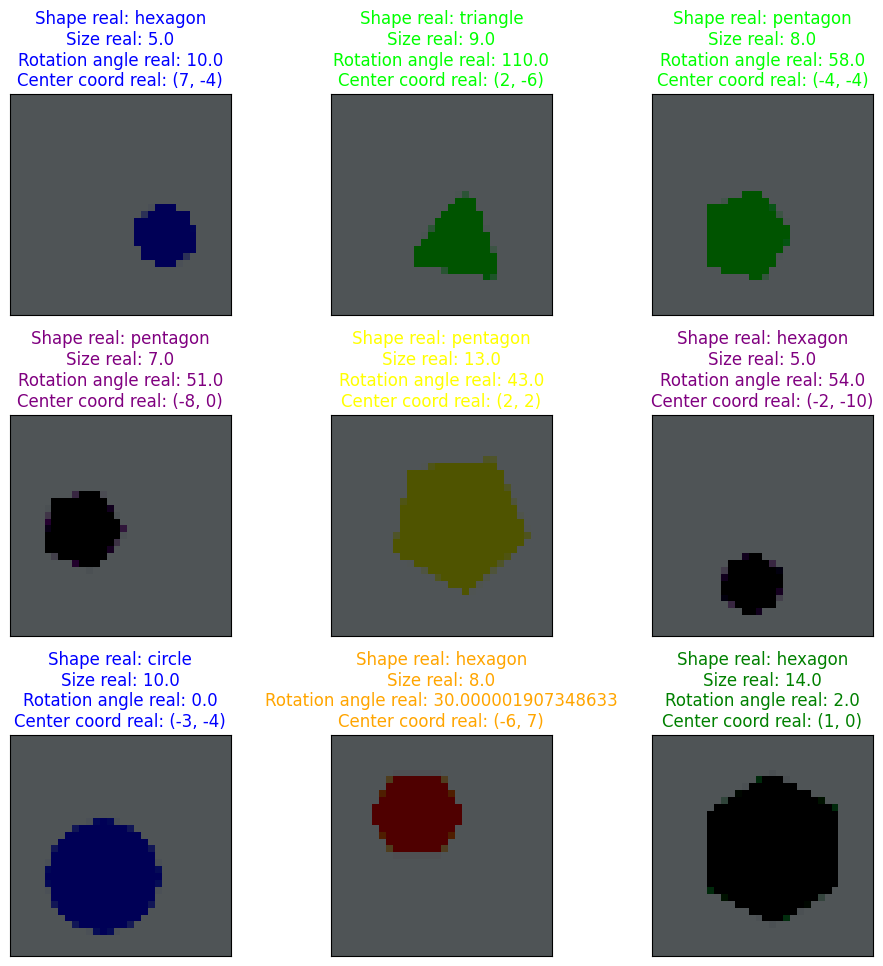

In [10]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(img_custom[i].permute(1, 2, 0))
    plt.title(f'Shape real: {scaler_shape.inverse_transform([np.array(shape_custom[i])]).item()}\n' 
                f'Size real: {scaler_size.inverse_transform(np.array(size_custom[i])[np.newaxis, np.newaxis]).item()}\n'
                f'Rotation angle real: {scaler_angle.inverse_transform(np.array(angle_custom[i])[np.newaxis, np.newaxis]).item()}\n'
                f'Center coord real: {(int(scaler_xcoord.inverse_transform(np.array(xcoord_custom[i])[np.newaxis, np.newaxis]).item()), int(scaler_ycoord.inverse_transform(np.array(ycoord_custom[i])[np.newaxis, np.newaxis]).item()))}', 
                fontdict={'color': scaler_color.inverse_transform([np.array(color_custom[i])]).item()})
    plt.xticks([])
    plt.yticks([])

In [11]:
model = Net()
loss_fn_categorical = nn.CrossEntropyLoss()
loss_fn_numeric = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

start_time = timer()

model_results = train.epohs(model=model,
                      train_loader=train_loader,
                      test_loader=test_loader,
                      optimizer=optimizer,
                      loss_fn_categorical=loss_fn_categorical,
                      loss_fn_numeric=loss_fn_numeric,
                      epochs=NUM_EPOCHS,
                      path='C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\\Testing\\Figure project\\files')

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

[19904/20000 (100%)]	Loss: 3.003578: : 312it [00:57,  5.43it/s]


Epoch: 1 | train_loss: 3.6869 | train_acc_cat: 0.2606 | test_loss: 2.9618 | test_acc_cat: 0.3306


[19904/20000 (100%)]	Loss: 1.638607: : 312it [00:59,  5.28it/s]


Epoch: 2 | train_loss: 2.2766 | train_acc_cat: 0.4618 | test_loss: 1.6213 | test_acc_cat: 0.6644


[19904/20000 (100%)]	Loss: 1.015540: : 312it [00:54,  5.76it/s]


Epoch: 3 | train_loss: 1.2603 | train_acc_cat: 0.7477 | test_loss: 0.6180 | test_acc_cat: 0.9344


[19904/20000 (100%)]	Loss: 0.777485: : 312it [00:50,  6.17it/s]


Epoch: 4 | train_loss: 0.8166 | train_acc_cat: 0.8748 | test_loss: 0.9970 | test_acc_cat: 0.9596


[19904/20000 (100%)]	Loss: 0.498304: : 312it [00:44,  7.01it/s]


Epoch: 5 | train_loss: 0.6119 | train_acc_cat: 0.9162 | test_loss: 0.3601 | test_acc_cat: 0.9772


[19904/20000 (100%)]	Loss: 0.478039: : 312it [00:56,  5.54it/s]


Epoch: 6 | train_loss: 0.4698 | train_acc_cat: 0.9431 | test_loss: 0.3568 | test_acc_cat: 0.9784


[19904/20000 (100%)]	Loss: 0.244189: : 312it [00:58,  5.37it/s]


Epoch: 7 | train_loss: 0.4020 | train_acc_cat: 0.9540 | test_loss: 0.2948 | test_acc_cat: 0.9838


[19904/20000 (100%)]	Loss: 0.274472: : 312it [01:00,  5.20it/s]


Epoch: 8 | train_loss: 0.3570 | train_acc_cat: 0.9644 | test_loss: 0.2107 | test_acc_cat: 0.9954


[19904/20000 (100%)]	Loss: 0.249098: : 312it [01:00,  5.20it/s]


Epoch: 9 | train_loss: 0.3074 | train_acc_cat: 0.9749 | test_loss: 0.1918 | test_acc_cat: 0.9986


[19904/20000 (100%)]	Loss: 0.240849: : 312it [01:00,  5.18it/s]


Epoch: 10 | train_loss: 0.2748 | train_acc_cat: 0.9769 | test_loss: 0.2010 | test_acc_cat: 0.9972


[19904/20000 (100%)]	Loss: 0.233062: : 312it [00:53,  5.83it/s]


Epoch: 11 | train_loss: 0.2577 | train_acc_cat: 0.9817 | test_loss: 0.2151 | test_acc_cat: 0.9970


[19904/20000 (100%)]	Loss: 0.080213: : 312it [00:43,  7.24it/s]


Epoch: 12 | train_loss: 0.2379 | train_acc_cat: 0.9815 | test_loss: 0.1649 | test_acc_cat: 0.9980


[19904/20000 (100%)]	Loss: 0.268710: : 312it [00:43,  7.22it/s]


Epoch: 13 | train_loss: 0.2055 | train_acc_cat: 0.9861 | test_loss: 0.1294 | test_acc_cat: 0.9986


[19904/20000 (100%)]	Loss: 0.173272: : 312it [00:42,  7.40it/s]


Epoch: 14 | train_loss: 0.2044 | train_acc_cat: 0.9883 | test_loss: 0.1401 | test_acc_cat: 0.9886


[19904/20000 (100%)]	Loss: 0.140751: : 312it [00:44,  6.95it/s]


Epoch: 15 | train_loss: 0.1933 | train_acc_cat: 0.9897 | test_loss: 0.1204 | test_acc_cat: 0.9990


[19904/20000 (100%)]	Loss: 0.177277: : 312it [00:42,  7.32it/s]


Epoch: 16 | train_loss: 0.1853 | train_acc_cat: 0.9899 | test_loss: 0.1183 | test_acc_cat: 0.9974


[19904/20000 (100%)]	Loss: 0.140575: : 312it [00:42,  7.42it/s]


Epoch: 17 | train_loss: 0.1658 | train_acc_cat: 0.9902 | test_loss: 0.1279 | test_acc_cat: 0.9996


[19904/20000 (100%)]	Loss: 0.119288: : 312it [00:41,  7.49it/s]


Epoch: 18 | train_loss: 0.1599 | train_acc_cat: 0.9913 | test_loss: 0.1114 | test_acc_cat: 0.9978


[19904/20000 (100%)]	Loss: 0.227267: : 312it [00:42,  7.26it/s]


Epoch: 19 | train_loss: 0.1638 | train_acc_cat: 0.9913 | test_loss: 0.0973 | test_acc_cat: 0.9990


[19904/20000 (100%)]	Loss: 0.109804: : 312it [00:43,  7.18it/s]


Epoch: 20 | train_loss: 0.1585 | train_acc_cat: 0.9903 | test_loss: 0.1177 | test_acc_cat: 0.9994

Test set: Accuracy: 4997/5000 (100%)

Total training time: 1105.676 seconds


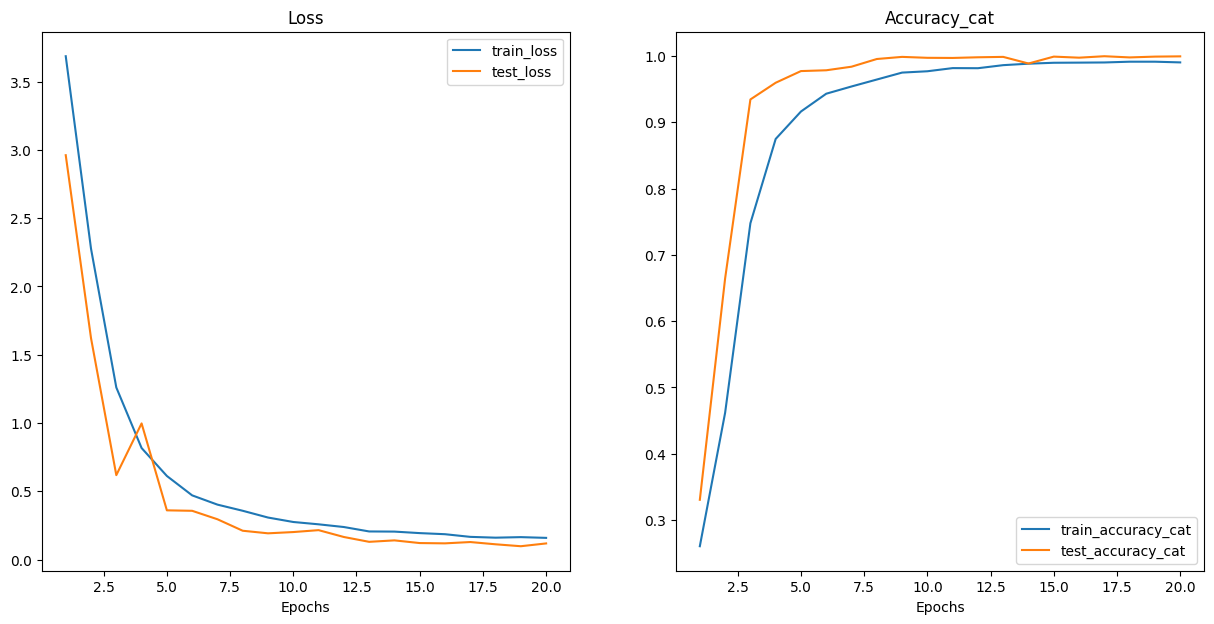

In [12]:
train.plot_loss_curves(model_results)

In [13]:
eval_data = CustomDataset(images=img_arr,
                            labels=labels,
                            transformation=transform)
eval_loader =torch.utils.data.DataLoader(eval_data,
                                        batch_size=1000,
                                        shuffle=True)

img_eval, shape_eval, color_eval, size_eval, angle_eval, xcoord_eval, ycoord_eval = next(iter(eval_loader))

In [14]:
with torch.inference_mode():
    output = model(img_eval)

In [15]:
print(f"Shape correct: {(output[0].data.max(1, keepdim=True)[1].flatten() == shape_eval).sum().item()/len(shape_eval)*100:.1f}%")
print(f"Color correct: {(output[1].data.max(1, keepdim=True)[1].flatten() == color_eval).sum().item()/len(color_eval)*100:.1f}%")
print(f"Size R2_score: {r2_score(output[2].flatten(), size_eval):.3f}")
print(f"Rotation angle R2_score: {r2_score(output[3].flatten(), angle_eval):.3f}")
print(f"X_center R2_score: {r2_score(output[4].flatten(), xcoord_eval):.3f}")
print(f"Y_center R2_score: {r2_score(output[5].flatten(), ycoord_eval):.3f}")

Shape correct: 100.0%
Color correct: 100.0%
Size R2_score: 0.986
Rotation angle R2_score: 0.951
X_center R2_score: 0.979
Y_center R2_score: 0.978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


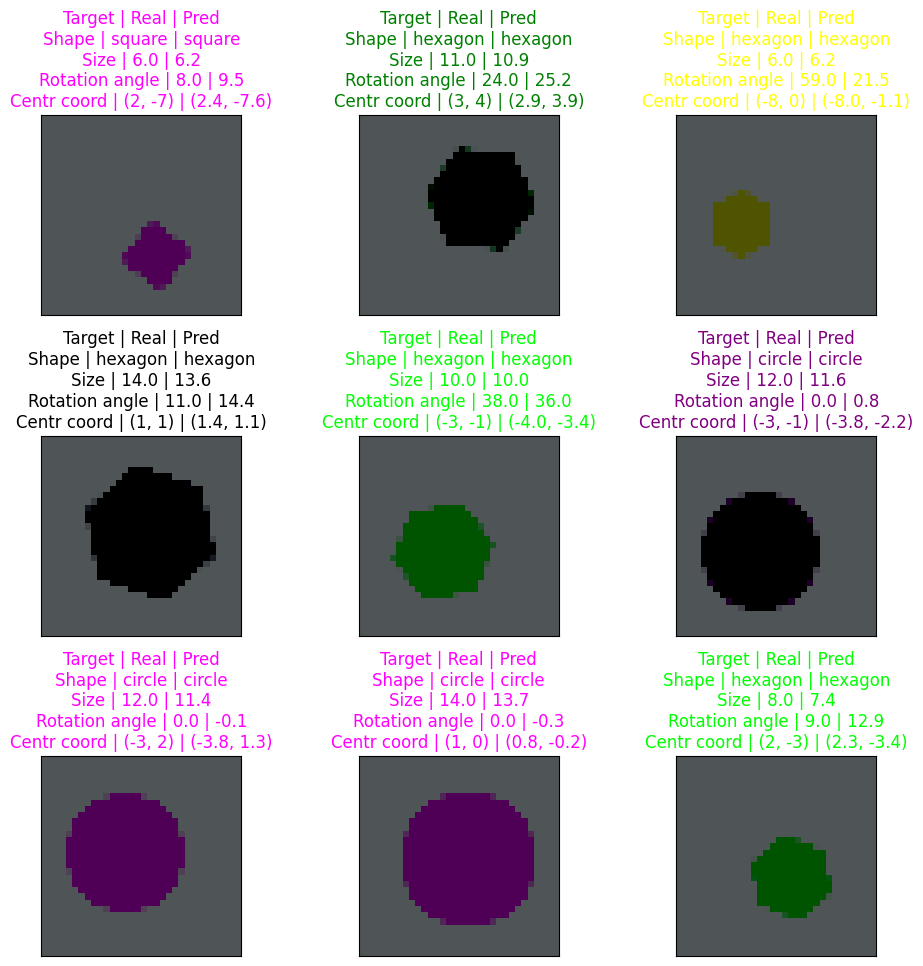

In [16]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(img_eval[i].permute(1, 2, 0))
    plt.title(f'Target | Real | Pred\n'
              f'Shape | {scaler_shape.inverse_transform([np.array(shape_eval[i])]).item()} | {scaler_shape.inverse_transform(np.array(output[0].data.max(1, keepdim=True)[1][i])).item()}\n'
              f'Size | {scaler_size.inverse_transform(np.array(size_eval[i])[np.newaxis, np.newaxis]).item()} | {round(scaler_size.inverse_transform(np.array(output[2][i])[:, np.newaxis]).item(), 1)}\n'
              f'Rotation angle | {round(scaler_angle.inverse_transform(np.array(angle_eval[i])[np.newaxis, np.newaxis]).item(), 1)} | {round(scaler_angle.inverse_transform(np.array(output[3][i])[:, np.newaxis]).item(), 1)}\n'
              f'Centr coord | {(int(scaler_xcoord.inverse_transform(np.array(xcoord_eval[i])[np.newaxis, np.newaxis]).item()), int(scaler_ycoord.inverse_transform(np.array(ycoord_eval[i])[np.newaxis, np.newaxis]).item()))} | {(round(scaler_xcoord.inverse_transform(np.array(output[4][i])[:, np.newaxis]).item(), 1), round(scaler_ycoord.inverse_transform(np.array(output[5][i])[:, np.newaxis]).item(), 1))}',
               fontdict={'color': scaler_color.inverse_transform(np.array(output[1].data.max(1, keepdim=True)[1][i])).item()})
    plt.xticks([])
    plt.yticks([])